In [23]:
#librerías, no es necesario volverlas a importar

import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras import initializers, regularizers, constraints, optimizers, layers, Sequential
from keras.utils import plot_model
from sklearn.metrics import classification_report

from gensim.models import Word2Vec



In [9]:
data_loader = os.path.join('..','0_Data','0_DataLoader.ipynb')
#Vectorizacion
%run $data_loader

[nltk_data] Downloading package punkt to /home/celeste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/celeste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celeste/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, acc, 'r', label='Training acc')
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training accuracy vs loss')
    plt.legend()

In [41]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(list(data.x_train) + list(data.x_val) + list(data.x_test))
len(tokenizer.word_index) + 1

22701

In [21]:
def run_model (train_x, train_y, val_x, val_y, test_x, test_y,
               embed_size, max_features, max_len, 
               batch_size, activationl1, nneuronsl1, epochs ):
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_x) + list(val_x))

    train_X = tokenizer.texts_to_sequences(train_x)
    train_X = pad_sequences(train_X, maxlen=max_len)

    val_X = tokenizer.texts_to_sequences(val_x)
    val_X = pad_sequences(val_X, maxlen=max_len)
    
    test_X = tokenizer.texts_to_sequences(test_x)
    test_X = pad_sequences(test_X, maxlen=max_len)

    model = Sequential()
    model.add(layers.Embedding(input_dim=max_features, 
                               output_dim=embed_size, 
                               input_length=max_len))
    model.add(layers.Flatten())
    model.add(layers.Dense(nneuronsl1, activation=activationl1))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    lr_schedule = ExponentialDecay(
        0.001,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    opt = Adam(learning_rate=lr_schedule)
    #opt = SGD()
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  
                 )
    #model.summary()

    history = model.fit(train_X, train_y,
                        epochs=epochs,
                        batch_size=batch_size,
                       validation_data=(val_X, val_y),
                       verbose=False)

    #plot_history(history)

    loss, accuracy = model.evaluate(train_X, train_y, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    
    loss, accuracy = model.evaluate(test_X, test_y, verbose=False)
    print("Testing Accuracy: {:.4f}".format(accuracy))
    test_pred_y = (model.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")
    print("Report: \n{}".format(classification_report(test_y, test_pred_y)))
    return model, tokenizer

# 1. Datos Originales

In [12]:
# Se cargan los datos 

data = get_data_original_as_np_array()


## 1.1 Comienzo con una cantidad de parametros grande

- vimos en el tp1 que los tweets tienen como máximo unas 35 palabras de modo que tomamos max_len = 50
- vimos tambien en el tp1 que el vocabulario es de aprox. 100.000 palabras pero el tokenizador reconoce 22700 así que comenzamos con un max_features = 30.000

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 300)           9000000   
_________________________________________________________________
flatten_16 (Flatten)         (None, 15000)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                240016    
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 9,240,033
Trainable params: 9,240,033
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9977
Testing Accuracy: 0.7781


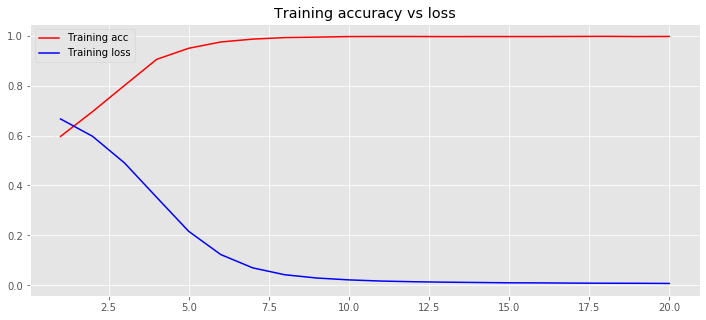

In [42]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=30000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

## 1.2. Busco reducir la cantidad de parametros para reducir el overfitting

### 1.2.1 pruebo reduciendo max_features

In [11]:
def test_max_features(start, end, step):
    for i in range (start, end, step):
        print ("max_features = {}".format(i) )
        run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=i, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)
        

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 50, 300)           3000000   
_________________________________________________________________
flatten_23 (Flatten)         (None, 15000)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 16)                240016    
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 17        
Total params: 3,240,033
Trainable params: 3,240,033
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9940
Testing Accuracy: 0.7814


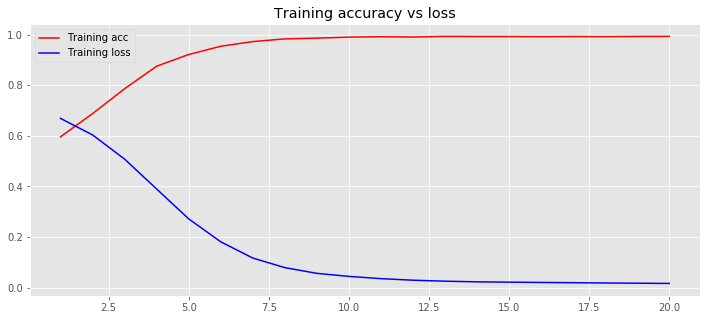

In [51]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=10000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

In [9]:
test_max_features(5000, 30000, 5000)

max_features = 5000
Training Accuracy: 0.9887
Testing Accuracy: 0.7676
max_features = 10000
Training Accuracy: 0.9940
Testing Accuracy: 0.7794
max_features = 15000
Training Accuracy: 0.9961
Testing Accuracy: 0.6632
max_features = 20000
Training Accuracy: 0.9977
Testing Accuracy: 0.7663
max_features = 25000
Training Accuracy: 0.9977
Testing Accuracy: 0.7695


In [12]:
test_max_features(10000, 20001, 2000)

max_features = 10000
Training Accuracy: 0.9936
Testing Accuracy: 0.7807
max_features = 12000
Training Accuracy: 0.9951
Testing Accuracy: 0.7833
max_features = 14000
Training Accuracy: 0.9971
Testing Accuracy: 0.7846
max_features = 16000
Training Accuracy: 0.9977
Testing Accuracy: 0.7715
max_features = 18000
Training Accuracy: 0.9977
Testing Accuracy: 0.7695
max_features = 20000
Training Accuracy: 0.9977
Testing Accuracy: 0.7754


In [13]:
test_max_features(9000, 14001, 500)

max_features = 9000
Training Accuracy: 0.9932
Testing Accuracy: 0.7728
max_features = 9500
Training Accuracy: 0.9934
Testing Accuracy: 0.7814
max_features = 10000
Training Accuracy: 0.9940
Testing Accuracy: 0.7840
max_features = 10500
Training Accuracy: 0.9943
Testing Accuracy: 0.7768
max_features = 11000
Training Accuracy: 0.9943
Testing Accuracy: 0.7873
max_features = 11500
Training Accuracy: 0.9947
Testing Accuracy: 0.7748
max_features = 12000
Training Accuracy: 0.9945
Testing Accuracy: 0.7032
max_features = 12500
Training Accuracy: 0.9957
Testing Accuracy: 0.7873
max_features = 13000
Training Accuracy: 0.9967
Testing Accuracy: 0.7833
max_features = 13500
Training Accuracy: 0.9973
Testing Accuracy: 0.7840
max_features = 14000
Training Accuracy: 0.9975
Testing Accuracy: 0.7827


### 1.2.2 Pruebo reduciendo max_len

- Tomo como valor el valor medio de la cantidad de palabras calculado en el tp1

In [14]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=12500, max_len = 15,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9955
Testing Accuracy: 0.7617


In [16]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=12500, max_len = 5,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9828
Testing Accuracy: 0.6645


In [20]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=12500, max_len = 30,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9959
Testing Accuracy: 0.7728


### 1.2.3 Pruebo reduciendo embed_size 

- Tamaño del vector de embeddings

In [21]:
def test_embed_size(start, end, step):
    for i in range (start, end, step):
        print ("embed_size = {}".format(i) )
        run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = i, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

In [23]:
test_embed_size(100, 301, 50)

embed_size = 100
Training Accuracy: 0.9957
Testing Accuracy: 0.7886
embed_size = 150
Training Accuracy: 0.9957
Testing Accuracy: 0.7859
embed_size = 200
Training Accuracy: 0.9959
Testing Accuracy: 0.7807
embed_size = 250
Training Accuracy: 0.9957
Testing Accuracy: 0.7866
embed_size = 300
Training Accuracy: 0.9953
Testing Accuracy: 0.7078


In [24]:
test_embed_size(50, 120, 10)

embed_size = 50
Training Accuracy: 0.9957
Testing Accuracy: 0.7814
embed_size = 60
Training Accuracy: 0.9957
Testing Accuracy: 0.7787
embed_size = 70
Training Accuracy: 0.9949
Testing Accuracy: 0.7912
embed_size = 80
Training Accuracy: 0.9957
Testing Accuracy: 0.7781
embed_size = 90
Training Accuracy: 0.9953
Testing Accuracy: 0.7833
embed_size = 100
Training Accuracy: 0.9957
Testing Accuracy: 0.7794
embed_size = 110
Training Accuracy: 0.9957
Testing Accuracy: 0.7689


### 1.2.4 Pruebo variando de a 2 variables 



In [25]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9957
Testing Accuracy: 0.7774
2/2 [==============================] - 0s 2ms/step
Report: 
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       869
           1       0.79      0.65      0.72       654

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523



In [24]:
model1, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=11000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9945
Testing Accuracy: 0.7827
2/2 [==============================] - 0s 2ms/step
Report: 
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       869
           1       0.77      0.71      0.74       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



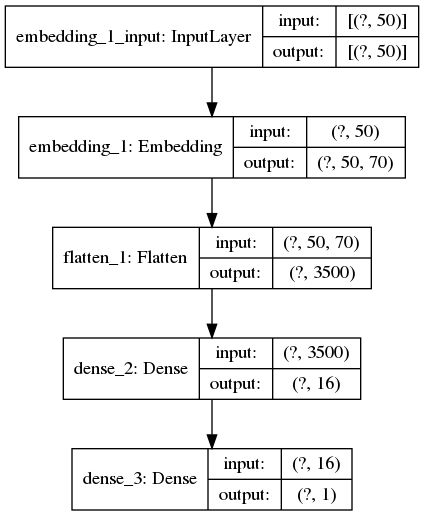

In [18]:
plot_model(model, to_file='PercepMultilayer.png', show_shapes=True)

In [66]:
pred_X = tokenizer.texts_to_sequences(data.predict)
pred_X = pad_sequences(pred_X, maxlen=50)

y_pred = (model.predict(pred_X, batch_size=512, verbose=1) > 0.5).astype("int32")

7/7 [==============================] - 0s 12ms/step


In [69]:
submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_pred
submission.to_csv("submission7.csv", index=False)

# 2. Datos Preprocesados

In [29]:
# Se cargan los datos 

data = get_data_sentiment_analysis_as_np_array()


## 2.1 Comienzo con una cantidad de parametros grande


In [30]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=30000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9897
Testing Accuracy: 0.7630
2/2 [==============================] - 0s 4ms/step
Report: 
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       869
           1       0.77      0.64      0.70       654

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



## 2.2. Busco reducir la cantidad de parametros para reducir el overfitting

### 2.2.1 pruebo reduciendo max_features

In [74]:
test_max_features(5000, 30000, 5000)

max_features = 5000
Training Accuracy: 0.9877
Testing Accuracy: 0.7735
max_features = 10000
Training Accuracy: 0.9889
Testing Accuracy: 0.6953
max_features = 15000
Training Accuracy: 0.9895
Testing Accuracy: 0.7787
max_features = 20000
Training Accuracy: 0.9889
Testing Accuracy: 0.6973
max_features = 25000
Training Accuracy: 0.9889
Testing Accuracy: 0.7019


In [75]:
test_max_features(10000, 20001, 2000)

max_features = 10000
Training Accuracy: 0.9889
Testing Accuracy: 0.7012
max_features = 12000
Training Accuracy: 0.9895
Testing Accuracy: 0.7722
max_features = 14000
Training Accuracy: 0.9887
Testing Accuracy: 0.7104
max_features = 16000
Training Accuracy: 0.9897
Testing Accuracy: 0.7669
max_features = 18000
Training Accuracy: 0.9885
Testing Accuracy: 0.7032
max_features = 20000
Training Accuracy: 0.9897
Testing Accuracy: 0.7728


In [76]:
test_max_features(11000, 14001, 1000)

max_features = 11000
Training Accuracy: 0.9895
Testing Accuracy: 0.7728
max_features = 12000
Training Accuracy: 0.9889
Testing Accuracy: 0.7032
max_features = 13000
Training Accuracy: 0.9895
Testing Accuracy: 0.7669
max_features = 14000
Training Accuracy: 0.9895
Testing Accuracy: 0.7702


In [79]:
test_max_features(11000, 13001, 500)

max_features = 11000
Training Accuracy: 0.9891
Testing Accuracy: 0.7722
max_features = 11500
Training Accuracy: 0.9895
Testing Accuracy: 0.7728
max_features = 12000
Training Accuracy: 0.9893
Testing Accuracy: 0.7715
max_features = 12500
Training Accuracy: 0.9893
Testing Accuracy: 0.7078
max_features = 13000
Training Accuracy: 0.9891
Testing Accuracy: 0.7058


### 2.2.2 Pruebo reduciendo embed_size 

- Tamaño del vector de embeddings

In [31]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9895
Testing Accuracy: 0.7689
2/2 [==============================] - 0s 4ms/step
Report: 
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       869
           1       0.76      0.67      0.71       654

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [32]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 200, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9893
Testing Accuracy: 0.7065
2/2 [==============================] - 0s 3ms/step
Report: 
              precision    recall  f1-score   support

           0       0.67      0.97      0.79       869
           1       0.90      0.36      0.51       654

    accuracy                           0.71      1523
   macro avg       0.78      0.66      0.65      1523
weighted avg       0.77      0.71      0.67      1523



In [33]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 100, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9883
Testing Accuracy: 0.6973
2/2 [==============================] - 0s 2ms/step
Report: 
              precision    recall  f1-score   support

           0       0.66      0.97      0.79       869
           1       0.89      0.33      0.49       654

    accuracy                           0.70      1523
   macro avg       0.78      0.65      0.64      1523
weighted avg       0.76      0.70      0.66      1523



In [34]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9891
Testing Accuracy: 0.7649
2/2 [==============================] - 0s 2ms/step
Report: 
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       869
           1       0.77      0.64      0.70       654

    accuracy                           0.76      1523
   macro avg       0.77      0.75      0.75      1523
weighted avg       0.77      0.76      0.76      1523

